In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tqdm import tqdm 
import warnings
warnings.filterwarnings(action = 'once')

In [2]:
# Importing the dataset
fileNames = ["metaData", "xaa_independent", "xaa_dependent"]
frames = []
for index, fileName in tqdm(enumerate(fileNames)):
    frames.append(dd.read_csv(fileName + ".csv", sep=",", sample = 2000000))

3it [00:12,  4.44s/it]


In [3]:
for i in range(3):
    frames[i] = frames[i].fillna(0)

In [4]:
X = frames[1].iloc[:, 1:].to_dask_array(lengths=True) # "lengths=True" counts the number of rows in the frame.
y = frames[2].iloc[:, 1:].to_dask_array(lengths=True)

In [5]:
X = np.array(X)

In [6]:
y = np.array(y)

In [7]:
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got

In [8]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [9]:
scaler_X.fit(X)
scaler_y.fit(y)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
scaled_X = scaler_X.transform(X)
scaled_y = scaler_y.transform(y)

In [11]:
scaled_X_train = scaled_X[:800, :]
scaled_y_train = scaled_y[:800, :]

scaled_X_test = scaled_X[800:, :]
scaled_y_test = scaled_y[800:, :]

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py:5851: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/daisuke/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibili

In [13]:
n_input = 10
n_features = X.shape[1] # number of features—i.e. the number of colums in the data

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=1)
# "length": the number of the rows that are used for prediction
# "batch_size": the number of the labels

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [15]:
model = Sequential()

# Add a LSTM layer to the neural network. 150 is the number of neurons in the layer. You need to play around with the number to find the best one. But 100 is a good number to try first.
model.add(LSTM(200, activation = 'relu', input_shape=(n_input, n_features)))
model.add(Dense(y.shape[1]))
model.compile(loss='mse', optimizer='adam')

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               18624800  
_________________________________________________________________
dense_1 (Dense)              (None, 1154)              231954    
Total params: 18,856,754
Trainable params: 18,856,754
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit_generator(generator,epochs=50)

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/50
790/790 [==============================] - 304s 385ms/step - loss: 0.0959
Epoch 2/50
790/790 [==============================] - 300s 379ms/step - loss: 0.0095
Epoch 3/50
790/790 [==============================] - 328s 415ms/step - loss: 0.0097
Epoch 4/50
790/790 [==============================] - 331s 419ms/step - loss: 0.0098
Epoch 5/50
  1/790 [..............................] - ETA: 5:39 - loss: 0.0089

KeyboardInterrupt: 

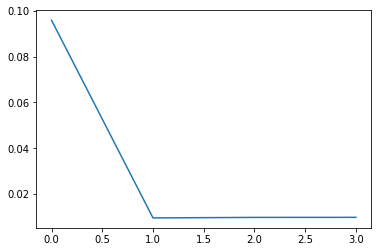

In [18]:
loss = model.history.history['loss']
epochs = range(len(loss))

plt.plot(epochs,loss)
plt.show()

In [19]:
# This variable holds  predicitons
test_predictions = [] 

# Uses last n_input points from the training set as a current_batch
first_eval_batch = scaled_X_train[-n_input:, :]
current_batch = first_eval_batch.reshape(1, n_input, n_features)
# Reshape so that the shape of first_eval_batch matches that of X of TimeseriesGenerator

# Predicts len(test) datapoints
for i in range(len(scaled_y_test)):
    current_pred = model.predict(current_batch)[0]
    
    # Store the current prediction
    test_predictions.append(current_pred)
    
    # Update the current batch by appending the current prediction
    current_batch = np.append(current_batch[:,1:,:], [[scaled_X_test[i, :]]], axis=1)
    #  axis = 1 means that [[current_pred] will be added to the second dimension of current_batch[:,1:,:]

In [20]:
test_predictions

[array([ 4.7439498e-01,  4.6802342e-01,  1.9076429e-03, ...,
        -2.3306608e-03,  6.0287043e-03,  6.1649829e-05], dtype=float32),
 array([ 0.47204265,  0.4668079 ,  0.00111098, ..., -0.00116757,
         0.00478248,  0.00059775], dtype=float32),
 array([ 0.4785712 ,  0.4678014 ,  0.00426603, ..., -0.0057116 ,
         0.01017779, -0.00133492], dtype=float32),
 array([ 4.6931985e-01,  4.5637694e-01,  3.7683137e-03, ...,
        -4.8114136e-03,  1.0682948e-02, -4.6830624e-04], dtype=float32),
 array([ 0.4718818 ,  0.45987675,  0.00377285, ..., -0.00487486,
         0.0102696 , -0.00064548], dtype=float32),
 array([ 4.7502267e-01,  4.6669975e-01,  2.7739145e-03, ...,
        -3.5523176e-03,  7.7022463e-03, -3.8940832e-04], dtype=float32),
 array([ 0.47804442,  0.46616364,  0.00462928, ..., -0.00620624,
         0.01100986, -0.00147008], dtype=float32),
 array([ 0.46471617,  0.45442605,  0.00203945, ..., -0.00229854,
         0.00789578,  0.00066086], dtype=float32),
 array([ 4.6873748

In [21]:
true_predictions = scaler_y.inverse_transform(test_predictions)

In [22]:
true_predictions

array([[-1.20841256e-03, -2.25091162e-03,  1.90764293e-03, ...,
        -2.33066082e-03,  6.02870435e-03,  6.16498291e-05],
       [-1.30675899e-03, -2.30356003e-03,  1.11098215e-03, ...,
        -1.16757303e-03,  4.78248298e-03,  5.97745180e-04],
       [-1.03381218e-03, -2.26052842e-03,  4.26603109e-03, ...,
        -5.71160018e-03,  1.01777911e-02, -1.33492053e-03],
       ...,
       [-1.00060183e-03, -1.96278467e-03,  1.97118893e-03, ...,
        -2.53009796e-03,  5.33907115e-03, -3.07910144e-04],
       [-6.98434302e-04, -1.77015185e-03,  4.13616747e-03, ...,
        -5.70946187e-03,  8.58804584e-03, -1.82182342e-03],
       [-8.29490189e-04, -2.05288308e-03,  5.02124056e-03, ...,
        -6.87342882e-03,  1.09208301e-02, -2.02468038e-03]])

In [23]:
df_pred = pd.DataFrame(true_predictions)

In [24]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153
0,-0.001208,-0.002251,0.001908,0.003577,0.000865,0.000266,-2.344348e-03,-0.008966,0.001301,0.005598,...,0.006209,-0.003210,0.004266,0.001688,0.001011,-0.002979,0.007917,-0.002331,0.006029,0.000062
1,-0.001307,-0.002304,0.001111,0.002929,0.000698,0.000084,-1.903385e-03,-0.008125,0.001236,0.004581,...,0.005360,-0.003473,0.003965,0.001575,0.000911,-0.002139,0.006623,-0.001168,0.004782,0.000598
2,-0.001034,-0.002261,0.004266,0.005780,0.001293,0.000780,-3.806200e-03,-0.012487,0.001356,0.009033,...,0.009258,-0.003000,0.005634,0.001905,0.001161,-0.005612,0.012395,-0.005712,0.010178,-0.001335
3,-0.001421,-0.002755,0.003768,0.006177,0.001002,0.000601,-3.967486e-03,-0.014835,0.000932,0.009583,...,0.010220,-0.004754,0.006777,0.001507,0.000699,-0.005500,0.013386,-0.004811,0.010683,-0.000468
4,-0.001313,-0.002604,0.003773,0.005918,0.001064,0.000624,-3.826948e-03,-0.013898,0.001058,0.009201,...,0.009736,-0.004232,0.006343,0.001615,0.000830,-0.005370,0.012804,-0.004875,0.010270,-0.000645
5,-0.001182,-0.002308,0.002774,0.004479,0.001001,0.000447,-2.932174e-03,-0.010594,0.001277,0.006998,...,0.007503,-0.003318,0.004924,0.001730,0.001019,-0.003994,0.009772,-0.003552,0.007702,-0.000389
6,-0.001056,-0.002331,0.004629,0.006240,0.001331,0.000850,-4.097026e-03,-0.013461,0.001307,0.009740,...,0.009952,-0.003207,0.006045,0.001890,0.001124,-0.006079,0.013355,-0.006206,0.011010,-0.001470
7,-0.001613,-0.002840,0.002039,0.004721,0.000651,0.000211,-2.982410e-03,-0.012823,0.000816,0.007300,...,0.008280,-0.005223,0.006038,0.001283,0.000509,-0.003652,0.010461,-0.002299,0.007896,0.000661
8,-0.001445,-0.002426,0.000435,0.002515,0.000525,-0.000081,-1.602843e-03,-0.007895,0.001117,0.003918,...,0.004890,-0.003964,0.003934,0.001424,0.000760,-0.001497,0.005828,-0.000152,0.003941,0.001142
9,-0.001563,-0.002395,-0.001383,0.000776,0.000205,-0.000475,-4.535206e-04,-0.005035,0.001094,0.001209,...,0.002464,-0.004046,0.002812,0.001273,0.000664,0.000555,0.002284,0.002446,0.000677,0.002192


In [25]:
df = pd.DataFrame(y[800:, :])

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153
0,0.007252,-0.001286,0.0,0.0,0.000716,0.0,0.0,0.0,0.004497,0.0,...,0.0,0.0,0.0,0.0,0.001060,0.0,0.0,0.0,0.0,0.0
1,0.009940,0.002363,0.0,0.0,0.000957,0.0,0.0,0.0,0.006369,0.0,...,0.0,0.0,0.0,0.0,0.002551,0.0,0.0,0.0,0.0,0.0
2,0.011062,0.002705,0.0,0.0,0.002927,0.0,0.0,0.0,0.006734,0.0,...,0.0,0.0,0.0,0.0,-0.001128,0.0,0.0,0.0,0.0,0.0
3,0.008585,0.005262,0.0,0.0,0.002058,0.0,0.0,0.0,0.007087,0.0,...,0.0,0.0,0.0,0.0,-0.002056,0.0,0.0,0.0,0.0,0.0
4,0.004777,0.007390,0.0,0.0,0.000361,0.0,0.0,0.0,0.008000,0.0,...,0.0,0.0,0.0,0.0,-0.002636,0.0,0.0,0.0,0.0,0.0
5,0.010857,0.009553,0.0,0.0,-0.002711,0.0,0.0,0.0,0.000852,0.0,...,0.0,0.0,0.0,0.0,0.001855,0.0,0.0,0.0,0.0,0.0
6,0.005608,0.003844,0.0,0.0,0.001596,0.0,0.0,0.0,0.000938,0.0,...,0.0,0.0,0.0,0.0,-0.001257,0.0,0.0,0.0,0.0,0.0
7,0.004163,0.005312,0.0,0.0,-0.001322,0.0,0.0,0.0,-0.000003,0.0,...,0.0,0.0,0.0,0.0,0.001748,0.0,0.0,0.0,0.0,0.0
8,0.003842,0.002772,0.0,0.0,-0.000575,0.0,0.0,0.0,-0.001025,0.0,...,0.0,0.0,0.0,0.0,0.004561,0.0,0.0,0.0,0.0,0.0
9,0.004244,0.002825,0.0,0.0,-0.000867,0.0,0.0,0.0,-0.003779,0.0,...,0.0,0.0,0.0,0.0,0.006695,0.0,0.0,0.0,0.0,0.0
